In [119]:
import os
os.environ["WANDB_API_KEY"] = "00c5bcfd2b2fbe9bce38152923c98635448f8c6f"

In [120]:
os.system('mkdir ../dataset') 
os.system('mkdir ../models')
os.system('wget -O ../dataset/KDDTrain+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt')
os.system('wget -O ../dataset/KDDTest+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt')
os.system('wget -O ../dataset/KDDTrain+_20Percent.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B_20Percent.txt')
os.system('wget -O ../dataset/KDDTest-21.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest-21.txt')
os.system('wget -O ../models/r2l_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/r2l_gen.pt')
os.system('wget -O ../models/u2r_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/u2r_gen.pt')
os.system('wget -O ../models/dos_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/dos_gen.pt')
os.system('wget -O ../models/probe_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/probe_gen.pt')
os.system('wget -O ../models/normal_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/normal_gen.pt')

0

In [121]:
os.system('pip install wandb -q')
os.system(f'wandb login {os.environ["WANDB_API_KEY"]}')
import wandb

In [122]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
#plt.style.use('grayscale')
from sklearn.metrics import precision_recall_curve,RocCurveDisplay
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn import preprocessing
import time

In [123]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [124]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [125]:
print(f'Using {device} as device')

Using cpu as device


In [126]:
class Critic(nn.Module):
  def __init__(self, data_dim):
    super(Critic,self).__init__()
    self.disc = nn.Sequential(
        nn.Conv1d(1,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Conv1d(3,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(111, data_dim),
    )

  def forward(self, x):
    return self.disc(x)


class Generator(nn.Module):
  def __init__(self, z_dim, data_dim):
    super(Generator,self).__init__()
    self.gen = nn.Sequential(
        nn.Conv1d(1,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Conv1d(3,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Linear(96, data_dim),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.gen(x)

In [127]:
def visualize_synthetic_data(generated, original, title):
  generated = generated[np.random.randint(0,len(generated),41)]
  original = original.iloc[np.random.randint(0,len(original),41),:41][:41]

  fig, (original_ax, synthesized_ax) = plt.subplots(1,2,figsize=(12,12))
  original_ax.set_title(f'Original({title})')
  synthesized_ax.set_title(f'Synthetic({title})')
  _ = original_ax.imshow(original)
  _ = synthesized_ax.imshow(generated)

In [128]:
def generate_data(generator, num_instances, z_dim):
  generator.eval()
  with torch.no_grad():
    out = generator(torch.randn(num_instances, z_dim).view(-1,1,z_dim))
    return out.detach().reshape(-1,41)[:num_instances]

In [129]:
def create_dataloader(X, y, batch_size):
  if y:
    y = np.array(X['41'])
  else:
    y = torch.ones(size=(X.shape[0],))
  y = torch.tensor(y, dtype=torch.float).to(device)

  X = np.array(X.iloc[:,:-1])
  X = torch.tensor(X, dtype=torch.float).to(device)

  pt_train = TensorDataset(X,y)
  pt_train = DataLoader(pt_train, batch_size=batch_size)
  return pt_train

In [130]:
def normalize_data(X):
  mms = MinMaxScaler()
  return mms.fit_transform(X)

In [131]:
def visualize_train_loss(loss_1, labels, epochs, loss_2 = None):
  plt.figure(figsize=(10,4))
  plt.plot(loss_1, linewidth=2)
  if loss_2:
    plt.plot(loss_2, linewidth=2)
  plt.legend(labels)
  plt.ylabel("loss")
  _ = plt.xlabel(f"epochs ({epochs})")

## Preprocessing

In [132]:
df=pd.read_csv('../dataset/KDDTrain+.txt', header=None)
df2=pd.read_csv('../dataset/KDDTest+.txt', header=None)

In [133]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [134]:
df.columns = [str(i) for i in range(0, len(df.columns))]
df2.columns = [str(i) for i in range(0, len(df2.columns))]

In [135]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)
df2.fillna(0, inplace=True)

In [136]:
# Peak on dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [137]:
df.shape

(125973, 43)

In [138]:
# Peak on the dataset
df.drop('42',axis=1, inplace=True)
df2.drop('42',axis=1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [139]:
sub_classes = df.iloc[:,41].value_counts()

In [140]:
print(sub_classes)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: 41, dtype: int64


In [141]:
r2l = ['ftp_write','guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient','warezmaster','xlock', 'xsnoop','named',
       'sendmail','snmpgetattack', 'snmpguess','httptunnel']
u2r = ['buffer_overflow', 'loadmodule','perl','ps','rootkit','sqlattack','xterm']
dos = ['back', 'land', 'neptune', 'smurf', 'teardrop','pod','mailbomb', 'processtable','udpstorm', 'worm','apache2']
probe = ['ipsweep', 'nmap', 'portsweep', 'satan','saint','mscan']
normal = ['normal']

In [142]:
pd.set_option('display.max_rows', None) # or 1000.
train_1 = df['1'].value_counts()
train_1.rename('Train', inplace=True)
test_1 = df2['1'].value_counts()
test_1.rename('Test', inplace=True)
cnct = pd.concat([train_1, test_1], axis = 1)
cnct

,Train,Test
tcp,102689,18880
udp,14993,2621
icmp,8291,1043


In [143]:
train_2 = df['2'].value_counts()
train_2.rename('Train', inplace=True)
test_2 = df2['2'].value_counts()
test_2.rename('Test', inplace=True)
cnct = pd.concat([train_2, test_2], axis = 1)
cnct

,Train,Test
http,40338,7853.0
private,21853,4774.0
domain_u,9043,894.0
smtp,7313,934.0
ftp_data,6860,851.0
eco_i,4586,262.0
other,4359,838.0
ecr_i,3077,752.0
telnet,2353,1626.0
finger,1767,136.0


In [144]:
train_3 = df['3'].value_counts()
train_3.rename('Train', inplace=True)
test_3 = df2['3'].value_counts()
test_3.rename('Test', inplace=True)
cnct = pd.concat([train_3, test_3], axis = 1)
cnct

,Train,Test
SF,74945,14875
S0,34851,2013
REJ,11233,3850
RSTR,2421,669
RSTO,1562,773
S1,365,21
SH,271,73
S2,127,15
RSTOS0,103,2
S3,49,249


In [145]:
df_X = df.drop('41', axis=1)
le = LabelEncoder()
for i in df_X:
  if df_X[i].dtype=='object':
    le.fit(df_X[i])
    df_X[i] = le.transform(df_X[i])
    df2[i] = le.transform(df2[i])
df.iloc[:,:40] = df_X

In [146]:
df.iloc[:,:40] = normalize_data(df.iloc[:,:40])
df2.iloc[:,:40] = normalize_data(df2.iloc[:,:40])

In [147]:
u2r_attacks = df[df['41'].apply(lambda x: x in u2r)].copy()
r2l_attacks = df[df['41'].apply(lambda x: x in r2l)].copy()
dos_attacks = df[df['41'].apply(lambda x: x in dos)].copy()
probe_attacks = df[df['41'].apply(lambda x: x in probe)].copy()
normal_traffic = df[df['41'].apply(lambda x: x in normal)].copy()

df['41'] = df['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

df2['41'] = df2['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

### Training set value counts

In [148]:
df['41'].value_counts()

normal       67343
malicious    58630
Name: 41, dtype: int64

### Testing set value counts

In [149]:
print(df2['41'].value_counts())

malicious    12833
normal        9711
Name: 41, dtype: int64


In [150]:
#In case of multi-class classification
#df_Y = le.fit(df['41']).transform(df['41'])
#df.iloc[:,41] = df_Y
#df_Y = le.transform(df2['41'])
#df2.iloc[:,41] = df_Y

#In case of binary classification
df.iloc[:,41] = df['41'].map(lambda x: 0 if x=='normal' else 1)
df2.iloc[:,41] = df2['41'].map(lambda x: 0 if x=='normal' else 1)

X_train = df.drop(['41'],axis=1)
y_train = df['41']

X_test = df2.drop(['41'],axis=1)
y_test = df2['41']
X_test = torch.tensor(np.array(X_test), dtype=torch.float, device=device)

**Creating TensorDataset**

In [151]:
pt_x_train = torch.tensor(X_train.to_numpy(), dtype=torch.float).to(device)
y = nn.functional.one_hot(torch.tensor(y_train.to_numpy()))
pt_y_train = y.float().to(device)
tensor_dataset = TensorDataset(pt_x_train, pt_y_train)

In [152]:
pt_x_train.shape, pt_y_train.shape

(torch.Size([125973, 41]), torch.Size([125973, 2]))

## **MLP**



In [153]:
class MLP(nn.Module):
  data_dim = 41
  def __init__(self):
      super(MLP, self).__init__()
      self.mlp = nn.Sequential(
          nn.Linear(self.data_dim, 80),
          nn.ReLU(),
          nn.BatchNorm1d(80)
      )
      '''self.cnn = nn.Sequential(
          nn.Conv1d(1,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Flatten(),
          nn.Linear(330, 24),
          nn.ReLU(),
      )'''

      self.clf = nn.Sequential(
          nn.Linear(80,2),
          nn.Sigmoid()
      )

  def forward(self, x):
      features = self.mlp(x)
      return self.clf(features)

  def transform(self, x):
      return self.cnn(x)

In [154]:
def validation_accuracy(model, X, y):
  model.eval()
  with torch.no_grad():
    lr_probs = model(X).detach().squeeze()
  preds = torch.argmax(lr_probs, dim=1).cpu()
  acc = accuracy_score(y, preds)
  model.train()
  return acc

In [155]:
batch_sizes = [32, 64, 128, 256]
epochs_ = [25, 40, 55, 70]
learning_rates = [1e-3, 1e-2, 1e-1]

In [156]:
start_time = time.time()

In [157]:
grid_scores = []
iters = 0
#Creating a Grid Search
for epochs in epochs_:
  for lr in learning_rates:
    for batch_size in batch_sizes:
      #Model init
      pt_train = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
      mlp = MLP().to(device)
      criterion = nn.BCELoss()
      optimizer = torch.optim.SGD(mlp.parameters(), lr = lr)
      
      #Training Loop
      run = wandb.init(entity='ahsen', project='nids', name=f'MLP_{iters}', group="MLP", reinit=True)
      wandb.config["lr"] = lr
      wandb.config["batch_size"] = batch_size
      wandb.config["epochs"] = epochs
      print('===============================================')
      print(f"Batch Size:{batch_size}\tEpochs:{epochs}\tLR:{lr}")
      num_epochs = epochs
      outputs = []
      losses = []
      for epoch in range(num_epochs):
          for instance, y in pt_train:
              output = mlp(instance)
              loss = criterion(output, y)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          losses.append(loss.item())
          acc = validation_accuracy(mlp, X_test, y_test)
          wandb.log({'loss':loss.item()})
          print('------------------------------------------------')
          print(f'Epoch:{epoch+1}  \tLoss:{loss.item():.4f}\t Acc: {acc:.4f}')

      print("*************************************************")
      print(f'Final Score for (B:{batch_size}, Ep:{epochs}, LR:{lr})')
      print(f'Acc: {acc:.4f}')
      #Save scores
      obj = {
        "config":{
          "learning_rate": lr,
          "epochs": epochs,
          "batch_size": batch_size,
          "acc": acc,
          },
        "weights": mlp.state_dict()
      }
      wandb.log({"acc" : acc})
      run.finish()
      grid_scores.append(obj)
      iters = iters + 1

Batch Size:32	Epochs:25	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.1850	 Acc: 0.7969
------------------------------------------------
Epoch:2  	Loss:0.1601	 Acc: 0.7900
------------------------------------------------
Epoch:3  	Loss:0.1550	 Acc: 0.7850
------------------------------------------------
Epoch:4  	Loss:0.1604	 Acc: 0.7855
------------------------------------------------
Epoch:5  	Loss:0.1570	 Acc: 0.7863
------------------------------------------------
Epoch:6  	Loss:0.1374	 Acc: 0.7775
------------------------------------------------
Epoch:7  	Loss:0.1252	 Acc: 0.7721
------------------------------------------------
Epoch:8  	Loss:0.1063	 Acc: 0.7720
------------------------------------------------
Epoch:9  	Loss:0.0945	 Acc: 0.7720
------------------------------------------------
Epoch:10  	Loss:0.0751	 Acc: 0.7716
------------------------------------------------
Epoch:11  	Loss:0.0700	 Acc: 0.7721
-----------------------------------------

acc,▁
loss,█▇▇▇▇▆▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
acc,0.785
loss,0.04412


Batch Size:64	Epochs:25	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2006	 Acc: 0.7645
------------------------------------------------
Epoch:2  	Loss:0.1681	 Acc: 0.7634
------------------------------------------------
Epoch:3  	Loss:0.1492	 Acc: 0.7672
------------------------------------------------
Epoch:4  	Loss:0.1343	 Acc: 0.7727
------------------------------------------------
Epoch:5  	Loss:0.1260	 Acc: 0.7721
------------------------------------------------
Epoch:6  	Loss:0.1206	 Acc: 0.7732
------------------------------------------------
Epoch:7  	Loss:0.1153	 Acc: 0.7728
------------------------------------------------
Epoch:8  	Loss:0.1067	 Acc: 0.7722
------------------------------------------------
Epoch:9  	Loss:0.1002	 Acc: 0.7737
------------------------------------------------
Epoch:10  	Loss:0.1022	 Acc: 0.7735
------------------------------------------------
Epoch:11  	Loss:0.1010	 Acc: 0.7735
-----------------------------------------

acc,▁
loss,█▆▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
acc,0.79427
loss,0.05149


Batch Size:128	Epochs:25	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2727	 Acc: 0.7669
------------------------------------------------
Epoch:2  	Loss:0.2419	 Acc: 0.7756
------------------------------------------------
Epoch:3  	Loss:0.2333	 Acc: 0.7813
------------------------------------------------
Epoch:4  	Loss:0.2139	 Acc: 0.7793
------------------------------------------------
Epoch:5  	Loss:0.2011	 Acc: 0.7771
------------------------------------------------
Epoch:6  	Loss:0.1845	 Acc: 0.7807
------------------------------------------------
Epoch:7  	Loss:0.1762	 Acc: 0.7790
------------------------------------------------
Epoch:8  	Loss:0.1650	 Acc: 0.7804
------------------------------------------------
Epoch:9  	Loss:0.1579	 Acc: 0.7807
------------------------------------------------
Epoch:10  	Loss:0.1576	 Acc: 0.7808
------------------------------------------------
Epoch:11  	Loss:0.1532	 Acc: 0.7791
----------------------------------------

acc,▁
loss,█▇▇▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
acc,0.78012
loss,0.08627


Batch Size:256	Epochs:25	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2594	 Acc: 0.7532
------------------------------------------------
Epoch:2  	Loss:0.2204	 Acc: 0.7605
------------------------------------------------
Epoch:3  	Loss:0.2074	 Acc: 0.7642
------------------------------------------------
Epoch:4  	Loss:0.2000	 Acc: 0.7786
------------------------------------------------
Epoch:5  	Loss:0.1943	 Acc: 0.7839
------------------------------------------------
Epoch:6  	Loss:0.1896	 Acc: 0.7957
------------------------------------------------
Epoch:7  	Loss:0.1864	 Acc: 0.7976
------------------------------------------------
Epoch:8  	Loss:0.1835	 Acc: 0.7974
------------------------------------------------
Epoch:9  	Loss:0.1801	 Acc: 0.7964
------------------------------------------------
Epoch:10  	Loss:0.1764	 Acc: 0.7952
------------------------------------------------
Epoch:11  	Loss:0.1713	 Acc: 0.7934
----------------------------------------

acc,▁
loss,█▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
acc,0.7866
loss,0.13551


Batch Size:32	Epochs:25	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0937	 Acc: 0.7854
------------------------------------------------
Epoch:2  	Loss:0.0938	 Acc: 0.7781
------------------------------------------------
Epoch:3  	Loss:0.0681	 Acc: 0.7773
------------------------------------------------
Epoch:4  	Loss:0.0473	 Acc: 0.7921
------------------------------------------------
Epoch:5  	Loss:0.0318	 Acc: 0.7922
------------------------------------------------
Epoch:6  	Loss:0.0298	 Acc: 0.7833
------------------------------------------------
Epoch:7  	Loss:0.0293	 Acc: 0.7777
------------------------------------------------
Epoch:8  	Loss:0.0325	 Acc: 0.7853
------------------------------------------------
Epoch:9  	Loss:0.0356	 Acc: 0.7682
------------------------------------------------
Epoch:10  	Loss:0.0281	 Acc: 0.7745
------------------------------------------------
Epoch:11  	Loss:0.0708	 Acc: 0.7656
------------------------------------------

acc,▁
loss,██▆▄▂▂▂▂▃▂▆▄▃▂▂█▃▃▃▂▂▁▁▁▂
acc,0.78411
loss,0.02365


Batch Size:64	Epochs:25	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1437	 Acc: 0.7689
------------------------------------------------
Epoch:2  	Loss:0.1004	 Acc: 0.7787
------------------------------------------------
Epoch:3  	Loss:0.1016	 Acc: 0.7779
------------------------------------------------
Epoch:4  	Loss:0.0815	 Acc: 0.7740
------------------------------------------------
Epoch:5  	Loss:0.0809	 Acc: 0.7814
------------------------------------------------
Epoch:6  	Loss:0.0814	 Acc: 0.7869
------------------------------------------------
Epoch:7  	Loss:0.0825	 Acc: 0.7809
------------------------------------------------
Epoch:8  	Loss:0.0618	 Acc: 0.7893
------------------------------------------------
Epoch:9  	Loss:0.0523	 Acc: 0.7936
------------------------------------------------
Epoch:10  	Loss:0.0850	 Acc: 0.7873
------------------------------------------------
Epoch:11  	Loss:0.0460	 Acc: 0.7916
------------------------------------------

acc,▁
loss,█▅▆▄▄▄▄▃▃▅▂▄▃▂▂▂▆▂▃▁▂▁▂▂▂
acc,0.78305
loss,0.04238


Batch Size:128	Epochs:25	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1737	 Acc: 0.7728
------------------------------------------------
Epoch:2  	Loss:0.1069	 Acc: 0.7680
------------------------------------------------
Epoch:3  	Loss:0.0915	 Acc: 0.7790
------------------------------------------------
Epoch:4  	Loss:0.0895	 Acc: 0.7743
------------------------------------------------
Epoch:5  	Loss:0.0781	 Acc: 0.7916
------------------------------------------------
Epoch:6  	Loss:0.0837	 Acc: 0.7866
------------------------------------------------
Epoch:7  	Loss:0.0787	 Acc: 0.7853
------------------------------------------------
Epoch:8  	Loss:0.0732	 Acc: 0.7896
------------------------------------------------
Epoch:9  	Loss:0.0651	 Acc: 0.7890
------------------------------------------------
Epoch:10  	Loss:0.0638	 Acc: 0.7904
------------------------------------------------
Epoch:11  	Loss:0.0698	 Acc: 0.7888
-----------------------------------------

acc,▁
loss,█▅▄▄▃▄▃▃▃▃▃▄▃▃▂▂▂▂▂▂▁▁▁▁▁
acc,0.78673
loss,0.03042


Batch Size:256	Epochs:25	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1688	 Acc: 0.7638
------------------------------------------------
Epoch:2  	Loss:0.1317	 Acc: 0.7757
------------------------------------------------
Epoch:3  	Loss:0.1171	 Acc: 0.7792
------------------------------------------------
Epoch:4  	Loss:0.1097	 Acc: 0.7852
------------------------------------------------
Epoch:5  	Loss:0.1054	 Acc: 0.7867
------------------------------------------------
Epoch:6  	Loss:0.0979	 Acc: 0.7810
------------------------------------------------
Epoch:7  	Loss:0.0842	 Acc: 0.7969
------------------------------------------------
Epoch:8  	Loss:0.0771	 Acc: 0.7977
------------------------------------------------
Epoch:9  	Loss:0.0700	 Acc: 0.7963
------------------------------------------------
Epoch:10  	Loss:0.0623	 Acc: 0.7961
------------------------------------------------
Epoch:11  	Loss:0.0565	 Acc: 0.7952
-----------------------------------------

acc,▁
loss,█▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
acc,0.79085
loss,0.02861


Batch Size:32	Epochs:25	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0804	 Acc: 0.7738
------------------------------------------------
Epoch:2  	Loss:0.0618	 Acc: 0.7858
------------------------------------------------
Epoch:3  	Loss:0.0304	 Acc: 0.7811
------------------------------------------------
Epoch:4  	Loss:0.0359	 Acc: 0.7858
------------------------------------------------
Epoch:5  	Loss:0.0336	 Acc: 0.7865
------------------------------------------------
Epoch:6  	Loss:0.0334	 Acc: 0.7908
------------------------------------------------
Epoch:7  	Loss:0.0378	 Acc: 0.7914
------------------------------------------------
Epoch:8  	Loss:0.0319	 Acc: 0.7864
------------------------------------------------
Epoch:9  	Loss:0.0285	 Acc: 0.7814
------------------------------------------------
Epoch:10  	Loss:0.0262	 Acc: 0.7762
------------------------------------------------
Epoch:11  	Loss:0.0205	 Acc: 0.7844
-------------------------------------------

acc,▁
loss,█▆▃▃▃▃▄▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
acc,0.79178
loss,0.01491


Batch Size:64	Epochs:25	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.1542	 Acc: 0.7924
------------------------------------------------
Epoch:2  	Loss:0.0478	 Acc: 0.7568
------------------------------------------------
Epoch:3  	Loss:0.1028	 Acc: 0.6985
------------------------------------------------
Epoch:4  	Loss:0.0331	 Acc: 0.7842
------------------------------------------------
Epoch:5  	Loss:0.0191	 Acc: 0.7695
------------------------------------------------
Epoch:6  	Loss:0.0348	 Acc: 0.7564
------------------------------------------------
Epoch:7  	Loss:0.0342	 Acc: 0.7814
------------------------------------------------
Epoch:8  	Loss:0.0252	 Acc: 0.7720
------------------------------------------------
Epoch:9  	Loss:0.0346	 Acc: 0.7713
------------------------------------------------
Epoch:10  	Loss:0.0984	 Acc: 0.7785
------------------------------------------------
Epoch:11  	Loss:0.0485	 Acc: 0.7758
-------------------------------------------

acc,▁
loss,█▂▅▂▁▂▂▁▂▅▃▂▃▂▁▃▁▁▁▂▅▆▄▃▅
acc,0.76464
loss,0.08788


Batch Size:128	Epochs:25	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.1161	 Acc: 0.7796
------------------------------------------------
Epoch:2  	Loss:0.0906	 Acc: 0.7835
------------------------------------------------
Epoch:3  	Loss:0.0340	 Acc: 0.7831
------------------------------------------------
Epoch:4  	Loss:0.0534	 Acc: 0.7811
------------------------------------------------
Epoch:5  	Loss:0.0416	 Acc: 0.7795
------------------------------------------------
Epoch:6  	Loss:0.0424	 Acc: 0.7876
------------------------------------------------
Epoch:7  	Loss:0.0677	 Acc: 0.7881
------------------------------------------------
Epoch:8  	Loss:0.0824	 Acc: 0.7836
------------------------------------------------
Epoch:9  	Loss:0.0574	 Acc: 0.7861
------------------------------------------------
Epoch:10  	Loss:0.0412	 Acc: 0.7813
------------------------------------------------
Epoch:11  	Loss:0.0327	 Acc: 0.7936
------------------------------------------

acc,▁
loss,█▆▂▃▂▃▄▆▄▂▂▃▃▃▃▂▄▃▁▂▂▂▁▂▂
acc,0.77732
loss,0.03403


Batch Size:256	Epochs:25	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0768	 Acc: 0.7899
------------------------------------------------
Epoch:2  	Loss:0.0839	 Acc: 0.8441
------------------------------------------------
Epoch:3  	Loss:0.0493	 Acc: 0.7983
------------------------------------------------
Epoch:4  	Loss:0.1459	 Acc: 0.7975
------------------------------------------------
Epoch:5  	Loss:0.0472	 Acc: 0.7927
------------------------------------------------
Epoch:6  	Loss:0.0347	 Acc: 0.7827
------------------------------------------------
Epoch:7  	Loss:0.0406	 Acc: 0.7689
------------------------------------------------
Epoch:8  	Loss:0.0414	 Acc: 0.7560
------------------------------------------------
Epoch:9  	Loss:0.0414	 Acc: 0.7815
------------------------------------------------
Epoch:10  	Loss:0.0317	 Acc: 0.7722
------------------------------------------------
Epoch:11  	Loss:0.0222	 Acc: 0.7682
------------------------------------------

acc,▁
loss,▄▄▃█▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▆▂▅▃▂▂
acc,0.76765
loss,0.04155


Batch Size:32	Epochs:40	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.1587	 Acc: 0.7842
------------------------------------------------
Epoch:2  	Loss:0.1322	 Acc: 0.7851
------------------------------------------------
Epoch:3  	Loss:0.1308	 Acc: 0.7853
------------------------------------------------
Epoch:4  	Loss:0.1316	 Acc: 0.7838
------------------------------------------------
Epoch:5  	Loss:0.1341	 Acc: 0.7845
------------------------------------------------
Epoch:6  	Loss:0.1315	 Acc: 0.7846
------------------------------------------------
Epoch:7  	Loss:0.1303	 Acc: 0.7760
------------------------------------------------
Epoch:8  	Loss:0.1309	 Acc: 0.7756
------------------------------------------------
Epoch:9  	Loss:0.1225	 Acc: 0.7762
------------------------------------------------
Epoch:10  	Loss:0.1035	 Acc: 0.7779
------------------------------------------------
Epoch:11  	Loss:0.0986	 Acc: 0.7764
-----------------------------------------

acc,▁
loss,█▇▇▇▇▇▇▇▆▅▅▄▃▂▂▂▂▂▂▂▁▁▁▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁
acc,0.80571
loss,0.02005


Batch Size:64	Epochs:40	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2119	 Acc: 0.7966
------------------------------------------------
Epoch:2  	Loss:0.1802	 Acc: 0.7906
------------------------------------------------
Epoch:3  	Loss:0.1632	 Acc: 0.7871
------------------------------------------------
Epoch:4  	Loss:0.1567	 Acc: 0.7846
------------------------------------------------
Epoch:5  	Loss:0.1550	 Acc: 0.7853
------------------------------------------------
Epoch:6  	Loss:0.1530	 Acc: 0.7893
------------------------------------------------
Epoch:7  	Loss:0.1487	 Acc: 0.7865
------------------------------------------------
Epoch:8  	Loss:0.1462	 Acc: 0.7873
------------------------------------------------
Epoch:9  	Loss:0.1419	 Acc: 0.7871
------------------------------------------------
Epoch:10  	Loss:0.1376	 Acc: 0.7880
------------------------------------------------
Epoch:11  	Loss:0.1360	 Acc: 0.7884
-----------------------------------------

acc,▁
loss,█▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
acc,0.80172
loss,0.07112


Batch Size:128	Epochs:40	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2561	 Acc: 0.7733
------------------------------------------------
Epoch:2  	Loss:0.2212	 Acc: 0.7872
------------------------------------------------
Epoch:3  	Loss:0.2154	 Acc: 0.7895
------------------------------------------------
Epoch:4  	Loss:0.2096	 Acc: 0.7858
------------------------------------------------
Epoch:5  	Loss:0.2045	 Acc: 0.7847
------------------------------------------------
Epoch:6  	Loss:0.1987	 Acc: 0.7830
------------------------------------------------
Epoch:7  	Loss:0.1881	 Acc: 0.7818
------------------------------------------------
Epoch:8  	Loss:0.1784	 Acc: 0.7826
------------------------------------------------
Epoch:9  	Loss:0.1686	 Acc: 0.7827
------------------------------------------------
Epoch:10  	Loss:0.1642	 Acc: 0.7822
------------------------------------------------
Epoch:11  	Loss:0.1619	 Acc: 0.7818
----------------------------------------

acc,▁
loss,█▆▆▆▆▆▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
acc,0.77329
loss,0.09471


Batch Size:256	Epochs:40	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2898	 Acc: 0.7366
------------------------------------------------
Epoch:2  	Loss:0.2429	 Acc: 0.7496
------------------------------------------------
Epoch:3  	Loss:0.2279	 Acc: 0.7569
------------------------------------------------
Epoch:4  	Loss:0.2207	 Acc: 0.7611
------------------------------------------------
Epoch:5  	Loss:0.2151	 Acc: 0.7617
------------------------------------------------
Epoch:6  	Loss:0.2104	 Acc: 0.7599
------------------------------------------------
Epoch:7  	Loss:0.2067	 Acc: 0.7579
------------------------------------------------
Epoch:8  	Loss:0.2055	 Acc: 0.7528
------------------------------------------------
Epoch:9  	Loss:0.2046	 Acc: 0.7509
------------------------------------------------
Epoch:10  	Loss:0.2041	 Acc: 0.7500
------------------------------------------------
Epoch:11  	Loss:0.2032	 Acc: 0.7494
----------------------------------------

acc,▁
loss,█▆▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.74481
loss,0.14405


Batch Size:32	Epochs:40	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0921	 Acc: 0.7677
------------------------------------------------
Epoch:2  	Loss:0.1159	 Acc: 0.7708
------------------------------------------------
Epoch:3  	Loss:0.0608	 Acc: 0.7775
------------------------------------------------
Epoch:4  	Loss:0.0583	 Acc: 0.7696
------------------------------------------------
Epoch:5  	Loss:0.0628	 Acc: 0.7625
------------------------------------------------
Epoch:6  	Loss:0.0643	 Acc: 0.7743
------------------------------------------------
Epoch:7  	Loss:0.0471	 Acc: 0.7631
------------------------------------------------
Epoch:8  	Loss:0.0470	 Acc: 0.7699
------------------------------------------------
Epoch:9  	Loss:0.0374	 Acc: 0.7764
------------------------------------------------
Epoch:10  	Loss:0.0306	 Acc: 0.7864
------------------------------------------------
Epoch:11  	Loss:0.0278	 Acc: 0.7790
------------------------------------------

acc,▁
loss,▆█▄▄▄▄▃▃▃▂▂▂▃▂▁▁▁▃▂▂▂▂▂▂▂▄▃▂▂▅▃▄▃▂▃▃▃▄▂▃
acc,0.78855
loss,0.03801


Batch Size:64	Epochs:40	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1058	 Acc: 0.7810
------------------------------------------------
Epoch:2  	Loss:0.0526	 Acc: 0.7616
------------------------------------------------
Epoch:3  	Loss:0.0535	 Acc: 0.7826
------------------------------------------------
Epoch:4  	Loss:0.0526	 Acc: 0.7769
------------------------------------------------
Epoch:5  	Loss:0.0498	 Acc: 0.7717
------------------------------------------------
Epoch:6  	Loss:0.0585	 Acc: 0.7733
------------------------------------------------
Epoch:7  	Loss:0.0506	 Acc: 0.7768
------------------------------------------------
Epoch:8  	Loss:0.0633	 Acc: 0.7701
------------------------------------------------
Epoch:9  	Loss:0.0528	 Acc: 0.7693
------------------------------------------------
Epoch:10  	Loss:0.0451	 Acc: 0.7670
------------------------------------------------
Epoch:11  	Loss:0.0665	 Acc: 0.7563
------------------------------------------

acc,▁
loss,▆▃▃▃▂▃▃▃▃▂▃▂▂▂▃▃▃▃▃▃▃▃▂▂▁▁▁▁▃▃▄▃▃▃█▆▁▂▂▂
acc,0.78384
loss,0.03256


Batch Size:128	Epochs:40	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1382	 Acc: 0.7910
------------------------------------------------
Epoch:2  	Loss:0.1070	 Acc: 0.7859
------------------------------------------------
Epoch:3  	Loss:0.0777	 Acc: 0.7779
------------------------------------------------
Epoch:4  	Loss:0.0653	 Acc: 0.7970
------------------------------------------------
Epoch:5  	Loss:0.0517	 Acc: 0.8011
------------------------------------------------
Epoch:6  	Loss:0.0552	 Acc: 0.8014
------------------------------------------------
Epoch:7  	Loss:0.0583	 Acc: 0.7995
------------------------------------------------
Epoch:8  	Loss:0.0473	 Acc: 0.8011
------------------------------------------------
Epoch:9  	Loss:0.0494	 Acc: 0.8029
------------------------------------------------
Epoch:10  	Loss:0.0518	 Acc: 0.8033
------------------------------------------------
Epoch:11  	Loss:0.0521	 Acc: 0.7972
-----------------------------------------

acc,▁
loss,█▆▅▄▃▃▃▃▃▃▃▃▂▃▂▂▃▂▂▂▂▁▂▂▂▂▂▂▁▁▃▁▁▁▁▂▁▁▁▁
acc,0.79875
loss,0.02274


Batch Size:256	Epochs:40	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1820	 Acc: 0.7517
------------------------------------------------
Epoch:2  	Loss:0.1531	 Acc: 0.7406
------------------------------------------------
Epoch:3  	Loss:0.1505	 Acc: 0.7411
------------------------------------------------
Epoch:4  	Loss:0.1544	 Acc: 0.7455
------------------------------------------------
Epoch:5  	Loss:0.1560	 Acc: 0.7461
------------------------------------------------
Epoch:6  	Loss:0.1399	 Acc: 0.7528
------------------------------------------------
Epoch:7  	Loss:0.0962	 Acc: 0.7645
------------------------------------------------
Epoch:8  	Loss:0.0993	 Acc: 0.7746
------------------------------------------------
Epoch:9  	Loss:0.0890	 Acc: 0.7752
------------------------------------------------
Epoch:10  	Loss:0.0889	 Acc: 0.7777
------------------------------------------------
Epoch:11  	Loss:0.0790	 Acc: 0.7784
-----------------------------------------

acc,▁
loss,█▇▇▇▇▆▄▄▄▄▃▃▃▃▂▂▂▂▃▃▂▃▃▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
acc,0.79201
loss,0.03519


Batch Size:32	Epochs:40	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0584	 Acc: 0.7979
------------------------------------------------
Epoch:2  	Loss:0.0892	 Acc: 0.7807
------------------------------------------------
Epoch:3  	Loss:0.0308	 Acc: 0.8015
------------------------------------------------
Epoch:4  	Loss:0.0404	 Acc: 0.7978
------------------------------------------------
Epoch:5  	Loss:0.0318	 Acc: 0.7981
------------------------------------------------
Epoch:6  	Loss:0.0347	 Acc: 0.7895
------------------------------------------------
Epoch:7  	Loss:0.0292	 Acc: 0.7901
------------------------------------------------
Epoch:8  	Loss:0.0275	 Acc: 0.7858
------------------------------------------------
Epoch:9  	Loss:0.0221	 Acc: 0.7795
------------------------------------------------
Epoch:10  	Loss:0.0200	 Acc: 0.7778
------------------------------------------------
Epoch:11  	Loss:0.0218	 Acc: 0.7862
-------------------------------------------

acc,▁
loss,▅█▃▄▃▃▃▃▂▂▂▂▄▃▃▃▄▃▃▃▃▃▃▃▂▂▃▂▂▂▃▂▃▁▁▁▁▁▁▁
acc,0.77524
loss,0.01159


Batch Size:64	Epochs:40	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.1099	 Acc: 0.7886
------------------------------------------------
Epoch:2  	Loss:0.0481	 Acc: 0.7915
------------------------------------------------
Epoch:3  	Loss:0.0422	 Acc: 0.7950
------------------------------------------------
Epoch:4  	Loss:0.0253	 Acc: 0.7926
------------------------------------------------
Epoch:5  	Loss:0.0415	 Acc: 0.7861
------------------------------------------------
Epoch:6  	Loss:0.0490	 Acc: 0.7891
------------------------------------------------
Epoch:7  	Loss:0.0475	 Acc: 0.7861
------------------------------------------------
Epoch:8  	Loss:0.0296	 Acc: 0.7893
------------------------------------------------
Epoch:9  	Loss:0.0398	 Acc: 0.7839
------------------------------------------------
Epoch:10  	Loss:0.0394	 Acc: 0.7813
------------------------------------------------
Epoch:11  	Loss:0.0384	 Acc: 0.7886
-------------------------------------------

acc,▁
loss,█▄▃▂▃▄▄▂▃▃▃▂▃▂▂▂▁▁▁▁▁▁▅▂▂▂▂▂▂▁▁▁▁▂▁▁▄▃▂▄
acc,0.77843
loss,0.0478


Batch Size:128	Epochs:40	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.1177	 Acc: 0.7638
------------------------------------------------
Epoch:2  	Loss:0.0965	 Acc: 0.7988
------------------------------------------------
Epoch:3  	Loss:0.0750	 Acc: 0.7963
------------------------------------------------
Epoch:4  	Loss:0.0576	 Acc: 0.7912
------------------------------------------------
Epoch:5  	Loss:0.1275	 Acc: 0.7657
------------------------------------------------
Epoch:6  	Loss:0.0867	 Acc: 0.7894
------------------------------------------------
Epoch:7  	Loss:0.0878	 Acc: 0.7978
------------------------------------------------
Epoch:8  	Loss:0.0467	 Acc: 0.8137
------------------------------------------------
Epoch:9  	Loss:0.0687	 Acc: 0.7827
------------------------------------------------
Epoch:10  	Loss:0.0327	 Acc: 0.7828
------------------------------------------------
Epoch:11  	Loss:0.0196	 Acc: 0.7913
------------------------------------------

acc,▁
loss,▇▆▅▄█▆▆▃▅▂▂▂▂▃▂▂▂▂▁▁▂▁▁▂▁▂▁▁▃▁▂▂▁▂▁▁▁▁▁▁
acc,0.77231
loss,0.007


Batch Size:256	Epochs:40	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0941	 Acc: 0.7893
------------------------------------------------
Epoch:2  	Loss:0.0701	 Acc: 0.7875
------------------------------------------------
Epoch:3  	Loss:0.0478	 Acc: 0.7883
------------------------------------------------
Epoch:4  	Loss:0.0466	 Acc: 0.7908
------------------------------------------------
Epoch:5  	Loss:0.0434	 Acc: 0.7835
------------------------------------------------
Epoch:6  	Loss:0.0554	 Acc: 0.7043
------------------------------------------------
Epoch:7  	Loss:0.0551	 Acc: 0.8055
------------------------------------------------
Epoch:8  	Loss:0.0415	 Acc: 0.7501
------------------------------------------------
Epoch:9  	Loss:0.0356	 Acc: 0.7979
------------------------------------------------
Epoch:10  	Loss:0.0393	 Acc: 0.8029
------------------------------------------------
Epoch:11  	Loss:0.0359	 Acc: 0.7901
------------------------------------------

acc,▁
loss,█▆▄▄▃▅▅▃▃▃▃▄▂▂▂▂▁▁▂▁▄▂▁▁▂▃▂▂▁▂▃▂▃▂▂▂▁▃▂▁
acc,0.78291
loss,0.01638


Batch Size:32	Epochs:55	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2072	 Acc: 0.7949
------------------------------------------------
Epoch:2  	Loss:0.1833	 Acc: 0.7859
------------------------------------------------
Epoch:3  	Loss:0.1545	 Acc: 0.7756
------------------------------------------------
Epoch:4  	Loss:0.1419	 Acc: 0.7752
------------------------------------------------
Epoch:5  	Loss:0.1141	 Acc: 0.7821
------------------------------------------------
Epoch:6  	Loss:0.1111	 Acc: 0.7791
------------------------------------------------
Epoch:7  	Loss:0.0987	 Acc: 0.7783
------------------------------------------------
Epoch:8  	Loss:0.0940	 Acc: 0.7781
------------------------------------------------
Epoch:9  	Loss:0.0903	 Acc: 0.7800
------------------------------------------------
Epoch:10  	Loss:0.0839	 Acc: 0.7872
------------------------------------------------
Epoch:11  	Loss:0.0745	 Acc: 0.7911
-----------------------------------------

acc,▁
loss,█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.80509
loss,0.01616


Batch Size:64	Epochs:55	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2114	 Acc: 0.7655
------------------------------------------------
Epoch:2  	Loss:0.1923	 Acc: 0.7681
------------------------------------------------
Epoch:3  	Loss:0.1830	 Acc: 0.7655
------------------------------------------------
Epoch:4  	Loss:0.1745	 Acc: 0.7616
------------------------------------------------
Epoch:5  	Loss:0.1630	 Acc: 0.7718
------------------------------------------------
Epoch:6  	Loss:0.1541	 Acc: 0.7737
------------------------------------------------
Epoch:7  	Loss:0.1422	 Acc: 0.7742
------------------------------------------------
Epoch:8  	Loss:0.1279	 Acc: 0.7742
------------------------------------------------
Epoch:9  	Loss:0.1162	 Acc: 0.7734
------------------------------------------------
Epoch:10  	Loss:0.1110	 Acc: 0.7724
------------------------------------------------
Epoch:11  	Loss:0.1072	 Acc: 0.7719
-----------------------------------------

acc,▁
loss,█▇▇▆▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.79879
loss,0.03788


Batch Size:128	Epochs:55	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.3022	 Acc: 0.7956
------------------------------------------------
Epoch:2  	Loss:0.2469	 Acc: 0.7962
------------------------------------------------
Epoch:3  	Loss:0.2276	 Acc: 0.7928
------------------------------------------------
Epoch:4  	Loss:0.2109	 Acc: 0.7870
------------------------------------------------
Epoch:5  	Loss:0.2038	 Acc: 0.7836
------------------------------------------------
Epoch:6  	Loss:0.2004	 Acc: 0.7821
------------------------------------------------
Epoch:7  	Loss:0.1935	 Acc: 0.7808
------------------------------------------------
Epoch:8  	Loss:0.1880	 Acc: 0.7796
------------------------------------------------
Epoch:9  	Loss:0.1829	 Acc: 0.7797
------------------------------------------------
Epoch:10  	Loss:0.1778	 Acc: 0.7796
------------------------------------------------
Epoch:11  	Loss:0.1720	 Acc: 0.7799
----------------------------------------

acc,▁
loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
acc,0.79831
loss,0.10356


Batch Size:256	Epochs:55	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2896	 Acc: 0.7480
------------------------------------------------
Epoch:2  	Loss:0.2502	 Acc: 0.7688
------------------------------------------------
Epoch:3  	Loss:0.2319	 Acc: 0.7800
------------------------------------------------
Epoch:4  	Loss:0.2209	 Acc: 0.7892
------------------------------------------------
Epoch:5  	Loss:0.2138	 Acc: 0.7909
------------------------------------------------
Epoch:6  	Loss:0.2064	 Acc: 0.7895
------------------------------------------------
Epoch:7  	Loss:0.1975	 Acc: 0.7873
------------------------------------------------
Epoch:8  	Loss:0.1871	 Acc: 0.7853
------------------------------------------------
Epoch:9  	Loss:0.1751	 Acc: 0.7831
------------------------------------------------
Epoch:10  	Loss:0.1689	 Acc: 0.7815
------------------------------------------------
Epoch:11  	Loss:0.1656	 Acc: 0.7775
----------------------------------------

acc,▁
loss,█▇▆▅▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
acc,0.78868
loss,0.09894


Batch Size:32	Epochs:55	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0777	 Acc: 0.7505
------------------------------------------------
Epoch:2  	Loss:0.0457	 Acc: 0.7833
------------------------------------------------
Epoch:3  	Loss:0.0354	 Acc: 0.7878
------------------------------------------------
Epoch:4  	Loss:0.0512	 Acc: 0.7793
------------------------------------------------
Epoch:5  	Loss:0.0391	 Acc: 0.7863
------------------------------------------------
Epoch:6  	Loss:0.0248	 Acc: 0.7787
------------------------------------------------
Epoch:7  	Loss:0.0204	 Acc: 0.7834
------------------------------------------------
Epoch:8  	Loss:0.0165	 Acc: 0.7833
------------------------------------------------
Epoch:9  	Loss:0.0203	 Acc: 0.7814
------------------------------------------------
Epoch:10  	Loss:0.0146	 Acc: 0.7789
------------------------------------------------
Epoch:11  	Loss:0.0355	 Acc: 0.7763
------------------------------------------

acc,▁
loss,▄▃▂▂▂▁▁▁▂▁▃▂▂▂▃▂▅▃▃▂▂▂▂▆▂▂█▇▆▃▂▅▃▂▂▂▃▁▂▁
acc,0.77169
loss,0.02042


Batch Size:64	Epochs:55	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1529	 Acc: 0.7748
------------------------------------------------
Epoch:2  	Loss:0.0994	 Acc: 0.7770
------------------------------------------------
Epoch:3  	Loss:0.0775	 Acc: 0.7711
------------------------------------------------
Epoch:4  	Loss:0.0606	 Acc: 0.7663
------------------------------------------------
Epoch:5  	Loss:0.0567	 Acc: 0.7699
------------------------------------------------
Epoch:6  	Loss:0.0446	 Acc: 0.7641
------------------------------------------------
Epoch:7  	Loss:0.0556	 Acc: 0.7591
------------------------------------------------
Epoch:8  	Loss:0.0535	 Acc: 0.7589
------------------------------------------------
Epoch:9  	Loss:0.0507	 Acc: 0.7791
------------------------------------------------
Epoch:10  	Loss:0.0409	 Acc: 0.7824
------------------------------------------------
Epoch:11  	Loss:0.0431	 Acc: 0.7784
------------------------------------------

acc,▁
loss,▇▅▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▃▁▂▆█▂▂▁▂▂▂▂▂▃▂▂
acc,0.78291
loss,0.04815


Batch Size:128	Epochs:55	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1606	 Acc: 0.7920
------------------------------------------------
Epoch:2  	Loss:0.1261	 Acc: 0.7894
------------------------------------------------
Epoch:3  	Loss:0.0954	 Acc: 0.7882
------------------------------------------------
Epoch:4  	Loss:0.0733	 Acc: 0.7855
------------------------------------------------
Epoch:5  	Loss:0.0596	 Acc: 0.7970
------------------------------------------------
Epoch:6  	Loss:0.0537	 Acc: 0.7967
------------------------------------------------
Epoch:7  	Loss:0.0477	 Acc: 0.7933
------------------------------------------------
Epoch:8  	Loss:0.0416	 Acc: 0.7928
------------------------------------------------
Epoch:9  	Loss:0.0388	 Acc: 0.7935
------------------------------------------------
Epoch:10  	Loss:0.0403	 Acc: 0.7945
------------------------------------------------
Epoch:11  	Loss:0.0381	 Acc: 0.7932
-----------------------------------------

acc,▁
loss,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▂▁▁▂▁▂▁▁▁▂▁▁▁
acc,0.7995
loss,0.01865


Batch Size:256	Epochs:55	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1900	 Acc: 0.7799
------------------------------------------------
Epoch:2  	Loss:0.1617	 Acc: 0.7775
------------------------------------------------
Epoch:3  	Loss:0.1436	 Acc: 0.7726
------------------------------------------------
Epoch:4  	Loss:0.1266	 Acc: 0.7715
------------------------------------------------
Epoch:5  	Loss:0.1170	 Acc: 0.7716
------------------------------------------------
Epoch:6  	Loss:0.1051	 Acc: 0.7707
------------------------------------------------
Epoch:7  	Loss:0.0936	 Acc: 0.7708
------------------------------------------------
Epoch:8  	Loss:0.0881	 Acc: 0.7703
------------------------------------------------
Epoch:9  	Loss:0.0822	 Acc: 0.7715
------------------------------------------------
Epoch:10  	Loss:0.0719	 Acc: 0.7690
------------------------------------------------
Epoch:11  	Loss:0.0700	 Acc: 0.7775
-----------------------------------------

acc,▁
loss,█▇▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▂▂▁▁▂▁▁
acc,0.75745
loss,0.03629


Batch Size:32	Epochs:55	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0869	 Acc: 0.7759
------------------------------------------------
Epoch:2  	Loss:0.0905	 Acc: 0.7489
------------------------------------------------
Epoch:3  	Loss:0.0676	 Acc: 0.7905
------------------------------------------------
Epoch:4  	Loss:0.0304	 Acc: 0.7906
------------------------------------------------
Epoch:5  	Loss:0.0380	 Acc: 0.7620
------------------------------------------------
Epoch:6  	Loss:0.0142	 Acc: 0.7843
------------------------------------------------
Epoch:7  	Loss:0.0205	 Acc: 0.7809
------------------------------------------------
Epoch:8  	Loss:0.0501	 Acc: 0.7814
------------------------------------------------
Epoch:9  	Loss:0.0239	 Acc: 0.7814
------------------------------------------------
Epoch:10  	Loss:0.0223	 Acc: 0.7784
------------------------------------------------
Epoch:11  	Loss:0.0240	 Acc: 0.7795
-------------------------------------------

acc,▁
loss,▃▄▃▂▁▁▁▁▁▁▁▁▂█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▂▂▂▂▂▂
acc,0.74734
loss,0.04103


Batch Size:64	Epochs:55	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0535	 Acc: 0.8036
------------------------------------------------
Epoch:2  	Loss:0.0416	 Acc: 0.7887
------------------------------------------------
Epoch:3  	Loss:0.0359	 Acc: 0.7821
------------------------------------------------
Epoch:4  	Loss:0.0562	 Acc: 0.7768
------------------------------------------------
Epoch:5  	Loss:0.0277	 Acc: 0.7872
------------------------------------------------
Epoch:6  	Loss:0.0516	 Acc: 0.8037
------------------------------------------------
Epoch:7  	Loss:0.0507	 Acc: 0.7854
------------------------------------------------
Epoch:8  	Loss:0.0447	 Acc: 0.7914
------------------------------------------------
Epoch:9  	Loss:0.0840	 Acc: 0.7916
------------------------------------------------
Epoch:10  	Loss:0.0503	 Acc: 0.7915
------------------------------------------------
Epoch:11  	Loss:0.0402	 Acc: 0.7935
-------------------------------------------

acc,▁
loss,▃▂▂▁▃▃▆▃▂▁▂▃▂▂▃▁▂▁▅▅▅▅█▄▄▂▃▂▃▃▃▃▂▂▂▂▂▂▂▁
acc,0.77196
loss,0.02958


Batch Size:128	Epochs:55	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.1318	 Acc: 0.8004
------------------------------------------------
Epoch:2  	Loss:0.0796	 Acc: 0.7838
------------------------------------------------
Epoch:3  	Loss:0.0430	 Acc: 0.7897
------------------------------------------------
Epoch:4  	Loss:0.0815	 Acc: 0.7876
------------------------------------------------
Epoch:5  	Loss:0.0387	 Acc: 0.7762
------------------------------------------------
Epoch:6  	Loss:0.0498	 Acc: 0.7695
------------------------------------------------
Epoch:7  	Loss:0.1124	 Acc: 0.7237
------------------------------------------------
Epoch:8  	Loss:0.0385	 Acc: 0.8034
------------------------------------------------
Epoch:9  	Loss:0.0446	 Acc: 0.7806
------------------------------------------------
Epoch:10  	Loss:0.0540	 Acc: 0.7855
------------------------------------------------
Epoch:11  	Loss:0.0977	 Acc: 0.7587
------------------------------------------

acc,▁
loss,▆▄▂▂▂▅▂▂█▅▂▁▂▂▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▂▂▃▄▄▂▂▃▂▂▂
acc,0.74171
loss,0.05407


Batch Size:256	Epochs:55	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.1183	 Acc: 0.7807
------------------------------------------------
Epoch:2  	Loss:0.0815	 Acc: 0.7842
------------------------------------------------
Epoch:3  	Loss:0.0652	 Acc: 0.7997
------------------------------------------------
Epoch:4  	Loss:0.0588	 Acc: 0.7821
------------------------------------------------
Epoch:5  	Loss:0.0459	 Acc: 0.7830
------------------------------------------------
Epoch:6  	Loss:0.0592	 Acc: 0.7750
------------------------------------------------
Epoch:7  	Loss:0.0363	 Acc: 0.7693
------------------------------------------------
Epoch:8  	Loss:0.0306	 Acc: 0.7789
------------------------------------------------
Epoch:9  	Loss:0.0399	 Acc: 0.7869
------------------------------------------------
Epoch:10  	Loss:0.0320	 Acc: 0.7740
------------------------------------------------
Epoch:11  	Loss:0.0402	 Acc: 0.7708
------------------------------------------

acc,▁
loss,█▆▄▃▄▃▃▂▁▂▂▂▃▃▂▃▂▅▃▃▂▂▂▂▂▂▃▄▂▂▄▃▂▂▂▁▁▂▂▂
acc,0.75253
loss,0.03068


Batch Size:32	Epochs:70	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2602	 Acc: 0.7857
------------------------------------------------
Epoch:2  	Loss:0.2311	 Acc: 0.7713
------------------------------------------------
Epoch:3  	Loss:0.2170	 Acc: 0.7638
------------------------------------------------
Epoch:4  	Loss:0.2002	 Acc: 0.7677
------------------------------------------------
Epoch:5  	Loss:0.1857	 Acc: 0.7744
------------------------------------------------
Epoch:6  	Loss:0.1731	 Acc: 0.7803
------------------------------------------------
Epoch:7  	Loss:0.1610	 Acc: 0.7815
------------------------------------------------
Epoch:8  	Loss:0.1527	 Acc: 0.7795
------------------------------------------------
Epoch:9  	Loss:0.1456	 Acc: 0.7798
------------------------------------------------
Epoch:10  	Loss:0.1387	 Acc: 0.7787
------------------------------------------------
Epoch:11  	Loss:0.1297	 Acc: 0.7818
-----------------------------------------

acc,▁
loss,█▇▆▅▅▅▄▄▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
acc,0.79627
loss,0.02405


Batch Size:64	Epochs:70	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2417	 Acc: 0.7824
------------------------------------------------
Epoch:2  	Loss:0.2158	 Acc: 0.7846
------------------------------------------------
Epoch:3  	Loss:0.1895	 Acc: 0.7812
------------------------------------------------
Epoch:4  	Loss:0.1702	 Acc: 0.7799
------------------------------------------------
Epoch:5  	Loss:0.1541	 Acc: 0.7780
------------------------------------------------
Epoch:6  	Loss:0.1452	 Acc: 0.7787
------------------------------------------------
Epoch:7  	Loss:0.1377	 Acc: 0.7796
------------------------------------------------
Epoch:8  	Loss:0.1307	 Acc: 0.7830
------------------------------------------------
Epoch:9  	Loss:0.1230	 Acc: 0.7850
------------------------------------------------
Epoch:10  	Loss:0.1184	 Acc: 0.7853
------------------------------------------------
Epoch:11  	Loss:0.1133	 Acc: 0.7855
-----------------------------------------

acc,▁
loss,█▇▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.78513
loss,0.03071


Batch Size:128	Epochs:70	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.2362	 Acc: 0.7622
------------------------------------------------
Epoch:2  	Loss:0.2042	 Acc: 0.7723
------------------------------------------------
Epoch:3  	Loss:0.1959	 Acc: 0.7695
------------------------------------------------
Epoch:4  	Loss:0.1861	 Acc: 0.7665
------------------------------------------------
Epoch:5  	Loss:0.1756	 Acc: 0.7641
------------------------------------------------
Epoch:6  	Loss:0.1699	 Acc: 0.7609
------------------------------------------------
Epoch:7  	Loss:0.1646	 Acc: 0.7594
------------------------------------------------
Epoch:8  	Loss:0.1604	 Acc: 0.7577
------------------------------------------------
Epoch:9  	Loss:0.1568	 Acc: 0.7575
------------------------------------------------
Epoch:10  	Loss:0.1536	 Acc: 0.7588
------------------------------------------------
Epoch:11  	Loss:0.1501	 Acc: 0.7606
----------------------------------------

acc,▁
loss,█▇▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
acc,0.78047
loss,0.04912


Batch Size:256	Epochs:70	LR:0.001
------------------------------------------------
Epoch:1  	Loss:0.3229	 Acc: 0.7682
------------------------------------------------
Epoch:2  	Loss:0.2836	 Acc: 0.7684
------------------------------------------------
Epoch:3  	Loss:0.2652	 Acc: 0.7846
------------------------------------------------
Epoch:4  	Loss:0.2493	 Acc: 0.7893
------------------------------------------------
Epoch:5  	Loss:0.2318	 Acc: 0.7905
------------------------------------------------
Epoch:6  	Loss:0.2236	 Acc: 0.7919
------------------------------------------------
Epoch:7  	Loss:0.2152	 Acc: 0.7941
------------------------------------------------
Epoch:8  	Loss:0.2069	 Acc: 0.7956
------------------------------------------------
Epoch:9  	Loss:0.1983	 Acc: 0.7953
------------------------------------------------
Epoch:10  	Loss:0.1896	 Acc: 0.7951
------------------------------------------------
Epoch:11  	Loss:0.1805	 Acc: 0.7944
----------------------------------------

acc,▁
loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
acc,0.77271
loss,0.08942


Batch Size:32	Epochs:70	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1192	 Acc: 0.7655
------------------------------------------------
Epoch:2  	Loss:0.0462	 Acc: 0.7982
------------------------------------------------
Epoch:3  	Loss:0.0407	 Acc: 0.7955
------------------------------------------------
Epoch:4  	Loss:0.0303	 Acc: 0.7950
------------------------------------------------
Epoch:5  	Loss:0.0385	 Acc: 0.7945
------------------------------------------------
Epoch:6  	Loss:0.0953	 Acc: 0.7958
------------------------------------------------
Epoch:7  	Loss:0.0488	 Acc: 0.7926
------------------------------------------------
Epoch:8  	Loss:0.0273	 Acc: 0.7894
------------------------------------------------
Epoch:9  	Loss:0.0284	 Acc: 0.7881
------------------------------------------------
Epoch:10  	Loss:0.0339	 Acc: 0.7905
------------------------------------------------
Epoch:11  	Loss:0.0296	 Acc: 0.7753
------------------------------------------

acc,▁
loss,█▃▂▆▂▂▂▃▂▂▃▂▂▂▁▅▂▂▂▃▂▁▂▂▃▄▂▁▂▂▂▂▂▂▂▂▂▃▄▃
acc,0.76841
loss,0.0406


Batch Size:64	Epochs:70	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1353	 Acc: 0.7615
------------------------------------------------
Epoch:2  	Loss:0.0900	 Acc: 0.7626
------------------------------------------------
Epoch:3  	Loss:0.0426	 Acc: 0.7596
------------------------------------------------
Epoch:4  	Loss:0.0570	 Acc: 0.7571
------------------------------------------------
Epoch:5  	Loss:0.0495	 Acc: 0.7779
------------------------------------------------
Epoch:6  	Loss:0.0420	 Acc: 0.7775
------------------------------------------------
Epoch:7  	Loss:0.0346	 Acc: 0.7844
------------------------------------------------
Epoch:8  	Loss:0.0379	 Acc: 0.7802
------------------------------------------------
Epoch:9  	Loss:0.0304	 Acc: 0.7811
------------------------------------------------
Epoch:10  	Loss:0.0271	 Acc: 0.7760
------------------------------------------------
Epoch:11  	Loss:0.0313	 Acc: 0.7874
------------------------------------------

acc,▁
loss,█▅▃▂▂▂▂▂▁▂▂▃▂▂▂▂▂▂▂▁▁▁▂▂▂▂▂▃▃▂▂▃▁▂▂▂▁▁▁▂
acc,0.78735
loss,0.032


Batch Size:128	Epochs:70	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1698	 Acc: 0.7802
------------------------------------------------
Epoch:2  	Loss:0.1395	 Acc: 0.7833
------------------------------------------------
Epoch:3  	Loss:0.1091	 Acc: 0.7837
------------------------------------------------
Epoch:4  	Loss:0.0912	 Acc: 0.7744
------------------------------------------------
Epoch:5  	Loss:0.0863	 Acc: 0.7757
------------------------------------------------
Epoch:6  	Loss:0.0763	 Acc: 0.7974
------------------------------------------------
Epoch:7  	Loss:0.0742	 Acc: 0.8054
------------------------------------------------
Epoch:8  	Loss:0.0587	 Acc: 0.7926
------------------------------------------------
Epoch:9  	Loss:0.0581	 Acc: 0.8016
------------------------------------------------
Epoch:10  	Loss:0.0525	 Acc: 0.8013
------------------------------------------------
Epoch:11  	Loss:0.0504	 Acc: 0.7922
-----------------------------------------

acc,▁
loss,█▆▄▃▂▂▂▂▁▁▃▁▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▂▂▂▁▁▁▁▁▁
acc,0.78234
loss,0.03399


Batch Size:256	Epochs:70	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.2005	 Acc: 0.7769
------------------------------------------------
Epoch:2  	Loss:0.1627	 Acc: 0.7676
------------------------------------------------
Epoch:3  	Loss:0.1494	 Acc: 0.7658
------------------------------------------------
Epoch:4  	Loss:0.1374	 Acc: 0.7670
------------------------------------------------
Epoch:5  	Loss:0.1213	 Acc: 0.7675
------------------------------------------------
Epoch:6  	Loss:0.1100	 Acc: 0.7682
------------------------------------------------
Epoch:7  	Loss:0.0977	 Acc: 0.7686
------------------------------------------------
Epoch:8  	Loss:0.0840	 Acc: 0.7696
------------------------------------------------
Epoch:9  	Loss:0.0710	 Acc: 0.7692
------------------------------------------------
Epoch:10  	Loss:0.0635	 Acc: 0.7771
------------------------------------------------
Epoch:11  	Loss:0.0599	 Acc: 0.7882
-----------------------------------------

acc,▁
loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.79835
loss,0.0145


Batch Size:32	Epochs:70	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0776	 Acc: 0.7932
------------------------------------------------
Epoch:2  	Loss:0.0603	 Acc: 0.7937
------------------------------------------------
Epoch:3  	Loss:0.1149	 Acc: 0.7413
------------------------------------------------
Epoch:4  	Loss:0.0337	 Acc: 0.7656
------------------------------------------------
Epoch:5  	Loss:0.0383	 Acc: 0.7633
------------------------------------------------
Epoch:6  	Loss:0.0319	 Acc: 0.7801
------------------------------------------------
Epoch:7  	Loss:0.0253	 Acc: 0.7731
------------------------------------------------
Epoch:8  	Loss:0.0248	 Acc: 0.7763
------------------------------------------------
Epoch:9  	Loss:0.0234	 Acc: 0.7729
------------------------------------------------
Epoch:10  	Loss:0.0201	 Acc: 0.7745
------------------------------------------------
Epoch:11  	Loss:0.0237	 Acc: 0.7583
-------------------------------------------

acc,▁
loss,█▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▂▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁
acc,0.75665
loss,0.01238


Batch Size:64	Epochs:70	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0533	 Acc: 0.7920
------------------------------------------------
Epoch:2  	Loss:0.0599	 Acc: 0.7747
------------------------------------------------
Epoch:3  	Loss:0.0427	 Acc: 0.7896
------------------------------------------------
Epoch:4  	Loss:0.0296	 Acc: 0.7902
------------------------------------------------
Epoch:5  	Loss:0.0257	 Acc: 0.7849
------------------------------------------------
Epoch:6  	Loss:0.0330	 Acc: 0.7842
------------------------------------------------
Epoch:7  	Loss:0.0187	 Acc: 0.7850
------------------------------------------------
Epoch:8  	Loss:0.0346	 Acc: 0.7752
------------------------------------------------
Epoch:9  	Loss:0.0265	 Acc: 0.7666
------------------------------------------------
Epoch:10  	Loss:0.0355	 Acc: 0.7375
------------------------------------------------
Epoch:11  	Loss:0.0807	 Acc: 0.7659
-------------------------------------------

acc,▁
loss,▄▅▃▃▃▂▆█▄▃▇▂▃▂▁▃▃▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
acc,0.78061
loss,0.01066


Batch Size:128	Epochs:70	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0726	 Acc: 0.7770
------------------------------------------------
Epoch:2  	Loss:0.1144	 Acc: 0.8149
------------------------------------------------
Epoch:3  	Loss:0.0578	 Acc: 0.7878
------------------------------------------------
Epoch:4  	Loss:0.0385	 Acc: 0.7765
------------------------------------------------
Epoch:5  	Loss:0.0286	 Acc: 0.7863
------------------------------------------------
Epoch:6  	Loss:0.0568	 Acc: 0.7932
------------------------------------------------
Epoch:7  	Loss:0.0372	 Acc: 0.7828
------------------------------------------------
Epoch:8  	Loss:0.0290	 Acc: 0.8025
------------------------------------------------
Epoch:9  	Loss:0.0352	 Acc: 0.7828
------------------------------------------------
Epoch:10  	Loss:0.0179	 Acc: 0.7845
------------------------------------------------
Epoch:11  	Loss:0.0223	 Acc: 0.7881
------------------------------------------

acc,▁
loss,▅█▂▄▂▂▁▁▂▃▃▂▂▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▃▂▂▂
acc,0.78367
loss,0.03721


Batch Size:256	Epochs:70	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.1441	 Acc: 0.8243
------------------------------------------------
Epoch:2  	Loss:0.0922	 Acc: 0.7951
------------------------------------------------
Epoch:3  	Loss:0.0536	 Acc: 0.7964
------------------------------------------------
Epoch:4  	Loss:0.0624	 Acc: 0.7906
------------------------------------------------
Epoch:5  	Loss:0.0379	 Acc: 0.7863
------------------------------------------------
Epoch:6  	Loss:0.0282	 Acc: 0.7927
------------------------------------------------
Epoch:7  	Loss:0.0439	 Acc: 0.7862
------------------------------------------------
Epoch:8  	Loss:0.0299	 Acc: 0.7829
------------------------------------------------
Epoch:9  	Loss:0.0389	 Acc: 0.7852
------------------------------------------------
Epoch:10  	Loss:0.0515	 Acc: 0.7862
------------------------------------------------
Epoch:11  	Loss:0.0213	 Acc: 0.7805
------------------------------------------

acc,▁
loss,█▅▄▂▂▃▂▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.80159
loss,0.00878


In [158]:
highest = 0
for i,score in enumerate(grid_scores):
  if score['config']['acc'] > grid_scores[highest]['config']['acc']:
    highest = i

{'acc': 0.8057132718239887,
 'batch_size': 32,
 'epochs': 40,
 'learning_rate': 0.001}

In [165]:
end_time = time.time()
print("=====================================")
print(f'Total time taken: {int(end_time-start_time)} seconds')
print(f'Best scores with\n{grid_scores[highest]["config"]}')

Total time taken: 6498 seconds
Best scores with
{'learning_rate': 0.001, 'epochs': 40, 'batch_size': 32, 'acc': 0.8057132718239887}


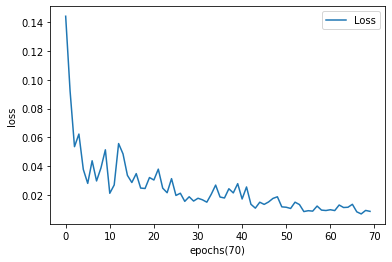

In [166]:
plt.plot(losses)
plt.xlabel(f"epochs({num_epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss'])

In [167]:
mlp.eval()
with torch.no_grad():
  #lr_probs = cnn(X_train.view(-1,1,1,41)).detach().squeeze()
  lr_probs = mlp(X_test).detach().squeeze()
probs = torch.max(lr_probs, dim=1)
idxs, scores = probs.indices, probs.values
probs = [scores[i].item() if idxs[i]==1 else 1-scores[i].item() for i in range(len(idxs))]
preds = torch.argmax(lr_probs, dim=1).cpu()
lr_probs = torch.max(lr_probs, dim=1).values
probs = np.array(probs)

In [168]:
suspicious = probs[(probs>0.4) & (probs<0.5)].shape[0]

In [169]:
print(f'{suspicious} packets are suspicious')

372 packets are suspicious


In [170]:
cm = confusion_matrix(y_test, preds)
tn=cm[1][1] #tn
fn=cm[0][1] #fn
fp=cm[1][0] #fp
tp=cm[0][0] #tp
acc= (tp+tn)/(tp+tn+fn+fp)
epsilon = 1e-7 # is used so that to avoid divide by zero error
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
print("Test accuracy is:"+str(format(acc,'.4f')))
print("Precision: "+str(format(precision,'.4f'))+"\nRecall: "+str(format(recall,'.4f')))

Test accuracy is:0.8016
Precision: 0.6935
Recall: 0.9667


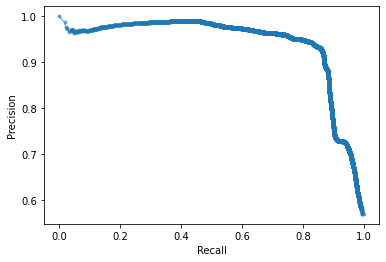

F1:	 79.518%
AUC:	 94.048%
Accuracy:80.159%


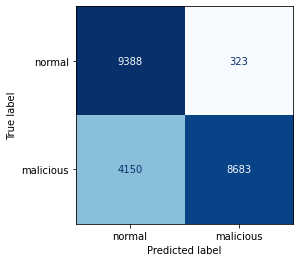

In [171]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, probs)
lr_f1, lr_auc = f1_score(y_test, preds), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==0]) / len(y_test)
acc = accuracy_score(y_test, preds)
plt.plot(lr_recall, lr_precision, marker='.', alpha=0.5)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the plot
plt.show()
_ = plt.rc('legend', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['normal', 'malicious'])
disp.plot(cmap="Blues", colorbar = False)
print(f"F1:\t {lr_f1*100:.3f}%")
print(f"AUC:\t {lr_auc*100:.3f}%")
print(f"Accuracy:{acc*100:.3f}%")

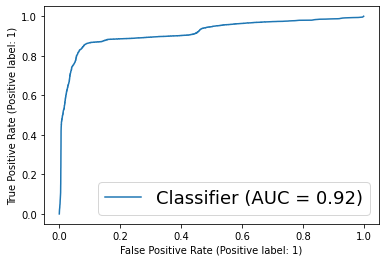

In [172]:
_ = RocCurveDisplay.from_predictions(y_test,probs)

In [173]:
wandb.finish()

In [174]:
torch.save(mlp.state_dict(), 'mlp.pt')